### Fringe Fitting
Version: 1.0

Created by: Zhiyuan Guo

Date: 10/14/2020

This notebook explores the pixel by pixel fitting method used in Walsh et al. https://ui.adsabs.harvard.edu/abs/2003acs..rept...12W/abstract for exploring the thickness variation of the Silicon detection layer in ACS HRC and WFC CCD.

E2V-CCD250-252 (One sensor implemented in RTM-005 on LSST focal plane) is used in this notebook for analysis.

The current version of this notebook shows how to extract 'Fringe amplitude' data for model fitting from TS data

TO DO: The next step is to fitting the data above using some analytical expression for the Fringe amplitude based on our Fringe Model.

In [1]:
%pylab inline
# Some useful functions
from astropy.io import fits
import lsst.eotest as eotest
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage

# eotest imports
import lsst.eotest.sensor as sensor
import lsst.eotest.image_utils as imutil

# Gaussian filter
from scipy.ndimage import gaussian_filter

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load Flat field data from TS8 in BNL
file_830 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_0830_4390_20170523193213.fits'
file_870 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_0870_4390_20170523193644.fits'
file_900 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_0900_4390_20170523194115.fits'
file_920 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_0920_4390_20170523194545.fits'
file_960 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_0960_4390_20170523195036.fits'
file_1000 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_1000_4390_20170523195614.fits'
file_1030 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_1030_4390_20170523200234.fits'

# Flat field without fringes
flat_600 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_0600_4390_20170523185234.fits'
flat_700 = '../../lsst_stack/data/E2V-CCD250-252_lambda_flat_0700_4390_20170523190949.fits'

# The assembled, overscan-corrected flat fields
flat_files = ['E2V_252_900nm.fits','E2V_252_920nm.fits','E2V_252_960nm.fits',
              'E2V_252_870nm.fits','E2V_252_1000nm.fits']


### The header file stores many useful information such as wavelength and width of the monochromatic light

In [3]:
hdu = fits.open(file_960)
hdu[0].header

SIMPLE  =                    T / Java FITS: Tue May 23 04:30:17 EDT 2017        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2017-05-23T19:50:54.196' / Creation Date and Time of File            
DATE-OBS= '2017-05-23T19:50:36.991' / Date of the observation (image acquisition
MJD     =   57896.827016157564 / Modified Julian Date that the file was written 
MJD-OBS = 57896.82681702543 / Modified Julian Date (5 decimal places) of image a
RUNNUM  = '4390    '           / The Run Number                                 
IMAGETAG= '1495569036991'      / Image tag (CCS/VST)                            
CONTNUM = '000018910d7f'       / CCD Controller Serial Number                   
SEQFILE = 'seq-e2v-shorterp-2s.seq' / Name of Sequencer File                    
CCD_MANU= 'E2V     '        

### Let's first see what does the sensor fringes look like in NIR

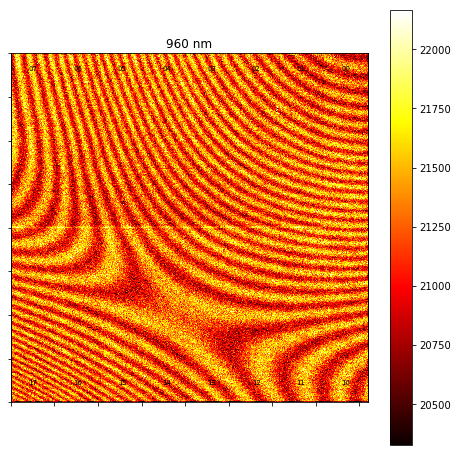

In [4]:
sensor.plot_flat(file_960,flatten=True,outfile = 'E2V_252_960nm.fits',figsize=(8,8))

In [5]:
# Define some function for plotting, adjusting the z-scale.

def cmap_range(image_array, nsig=5):
    pixel_data = np.array(image_array, dtype=np.float).flatten()
    stats = afwMath.makeStatistics(pixel_data,
                                   afwMath.STDEVCLIP | afwMath.MEDIAN)
    median = stats.getValue(afwMath.MEDIAN)
    stdev = stats.getValue(afwMath.STDEVCLIP)
    vmin = max(min(pixel_data), median - nsig*stdev)
    vmax = min(max(pixel_data), median + nsig*stdev)
    return vmin, vmax

def im_show (data):
    #plt.figure(figsize = (8,8))
    vmin, vmax = cmap_range(data)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    plt.imshow(data,origin='lower',norm=norm,cmap = pylab.cm.hot)
    plt.colorbar()

### Normalize the Flat field with the mean calculated base on spatial scale much larger than the fringe and Measure Fringe amplitude

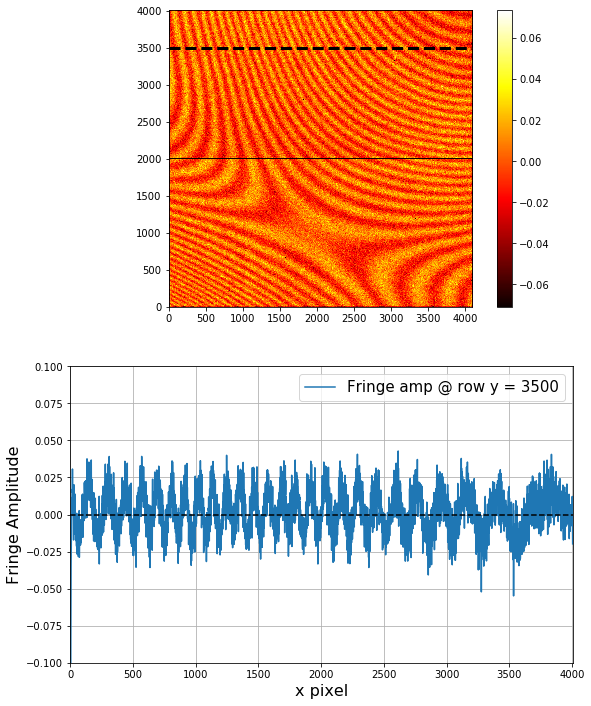

In [6]:
assem = fits.open('E2V_252_960nm.fits')
assembled = assem[0].data

# Normalize the the fringe flats via dividing the overall mean of the flat field.
Fringe_amp = assembled/np.mean(assembled)-1

# Plot results
plt.figure(figsize = (9,12))
plt.subplot(211)
im_show(Fringe_amp)

# Taking measure at row y = 3500
plt.axhline(3500,color = 'black',ls = '--',linewidth = 3)
plt.subplot(212)
plt.plot(Fringe_amp[3500,:],label = 'Fringe amp @ row y = 3500')
plt.ylabel('Fringe Amplitude',fontsize = 16)
plt.xlabel('x pixel',fontsize = 16)
plt.ylim(-0.1,0.1)
plt.xlim(0,4004)
plt.legend(loc = 'best',fontsize = 15)
plt.axhline(0,ls = '--',color = 'black')
plt.grid();

### The fringe amplitude oscillates around 0.025 (2.5 %) @ 960nm
### Maybe smoothing data a little bit using Gaussian filter

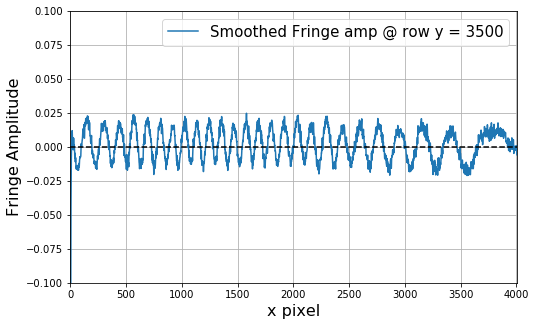

In [7]:
#Apply Gaussian filter
Fringe_amp = gaussian_filter(Fringe_amp,sigma = 1)

#Plot
plt.figure(figsize = (8,5))
plt.plot(Fringe_amp[3500,:],label = 'Smoothed Fringe amp @ row y = 3500')
plt.ylabel('Fringe Amplitude',fontsize = 16)
plt.xlabel('x pixel',fontsize = 16)
plt.ylim(-0.1,0.1)
plt.xlim(0,4004)
plt.legend(loc = 'best',fontsize = 15)
plt.axhline(0,ls = '--',color = 'black')
plt.grid();

### Follow the data point collection method described by Walsh et al. (The HRC paper) https://ui.adsabs.harvard.edu/abs/2003acs..rept...12W/abstract 
### For one specific wavelength, pick a coadded 3X3 pixel region in the sensor. Take the mean as the data point. And treat RMS on the mean over the 9 pixels as error bar. Repeat the process for Flat Field data in serveral wavelength.

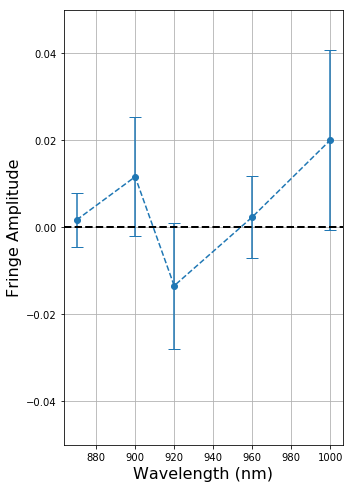

In [8]:
Fringe_amps = []
error = []
wlen = np.array([870,900,920,960,1000])
for file in flat_files:
    smooth = False
    assem = fits.open(file)
    assembled = assem[0].data
    Fringe_amp = assembled/np.mean(assembled)-1
    if smooth == True:
        Fringe_amp = gaussian_filter(Fringe_amp,sigma = 1)
    
    # Coadded region
    coadd_region = Fringe_amp[500:503,500:503]
    Fringe_amps.append(np.mean(coadd_region))
    rms = np.sqrt(np.mean((coadd_region)**2))
    error.append(rms)
    

plt.figure(figsize=(5,8))
plt.errorbar(wlen,np.array(Fringe_amps),yerr = np.array(error),fmt = '--o',capsize = 6)
plt.ylabel('Fringe Amplitude',fontsize = 16)
plt.ylim(-0.05,0.05)
plt.xlabel('Wavelength (nm)',fontsize = 16)
plt.axhline(0,ls = '--',color = 'black',linewidth = 2)
plt.grid();

### Compare with HRC paper :The crosses in the figure below is the data point in the HRC fringe paper
### The next step is to fitting the data above using some analytical expression for the Fringe amplitude based on our Fringe Model.

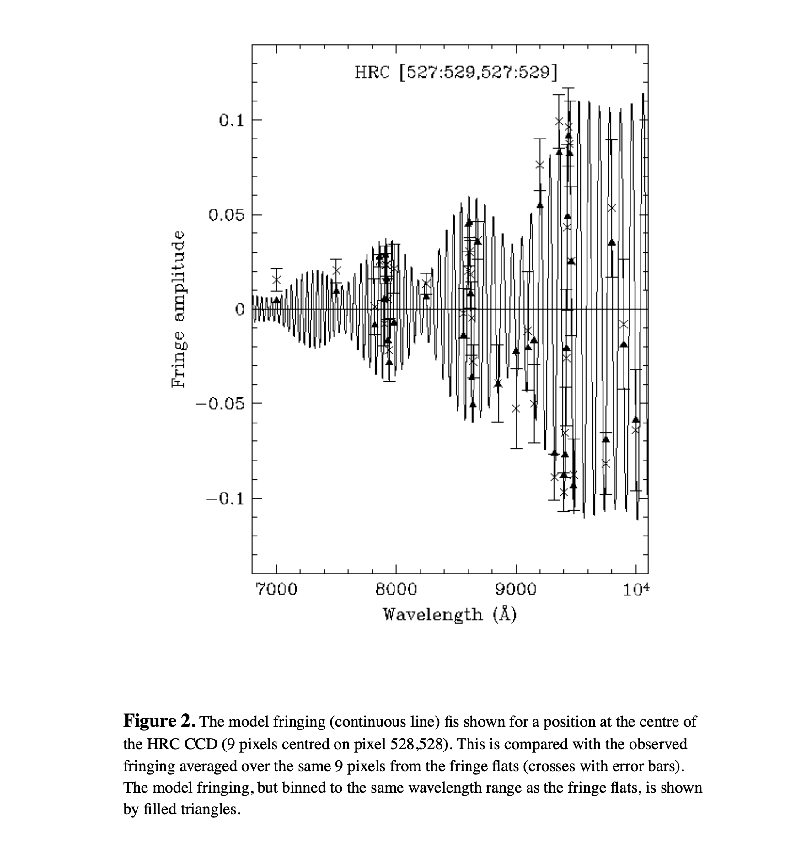

In [9]:
import matplotlib.image as mpimg
img = mpimg.imread('HRC-Fringe-amp-plot.png')
plt.figure(figsize = (15,15))
plt.imshow(img)
plt.axis('off');

In [10]:
#bias1 = fits.open(bias_file1)
#bias2 = fits.open(bias_file2)
#bias3 = fits.open(bias_file3)
#bias4 = fits.open(bias_file4)
#bias5 = fits.open(bias_file5)
#bias6 = fits.open(bias_file6)

In [11]:
#bias_file1 = '../../lsst_stack/data/BIAS/E2V-CCD250-252_lambda_bias_000_4390_20170523180103.fits'
#bias_file2 = '../../lsst_stack/data/BIAS/E2V-CCD250-252_lambda_bias_001_4390_20170523180638.fits'
#bias_file3 = '../../lsst_stack/data/BIAS/E2V-CCD250-252_lambda_bias_002_4390_20170523181154.fits'
#bias_file4 = '../../lsst_stack/data/BIAS/E2V-CCD250-252_lambda_bias_003_4390_20170523181632.fits'
#bias_file5 = '../../lsst_stack/data/BIAS/E2V-CCD250-252_lambda_bias_004_4390_20170523182056.fits'
#bias_file6 = '../../lsst_stack/data/BIAS/E2V-CCD250-252_lambda_bias_005_4390_20170523182514.fits'

In [12]:
#unbiased = []
#unbiased.append(unbias1[0].data)
#unbiased.append(unbias2[0].data)
#unbiased.append(unbias3[0].data)
#unbiased.append(unbias4[0].data)
#unbiased.append(unbias5[0].data)
#unbiased.append(unbias6[0].data)